# Model Evaluation

##### *In which we hope all the work we put into our model pays off.*

###### [GitHub Repository](https://github.com/ahester57/ai_workshop/tree/master/notebooks/time_for_crab/3-evaluation)

###### [Notebook Viewer](https://nbviewer.jupyter.org/github/ahester57/ai_workshop/blob/master/notebooks/time_for_crab/3-evaluation/evaluation.ipynb)

###### [Kaggle Dataset](https://www.kaggle.com/sidhus/crab-age-prediction)


## Abstract

*This project focused on the development of a regression model to predict the age of crabs based on a reduced set of features. Despite concerted efforts in feature engineering, prevention of data leakage, and hyperparameter tuning, the model's performance did not meet expectations. The primary issues identified were overfitting and potential multicollinearity among weight measurements.*  
*The model's complexity was selected prior to feature reduction, which may have contributed to the overfitting. This experience underscored the importance of reducing the number of features before deciding on the model architecture. It also highlighted the potential impact of multicollinearity on model performance.*  
*The project also involved tuning the hyperparameters of the model to improve its performance. However, this area seemed to suffer from the curse of dimensionality. The possibility of using machine learning algorithms to tune the hyperparameters was considered for future work.*
*Despite the model's performance not meeting expectations, the project was a great learning experience. It provided a deeper understanding of feature engineering, data leakage, regression metrics, and the challenges of model selection. The knowledge gained from this project will be invaluable for future machine learning projects.*


## Table of Contents

1. [Introduction](#Introduction)
    1. [Reasons for Choosing This Dataset](#Reasons-for-Choosing-This-Dataset)
    2. [Evaluation Strategy](#Evaluation-Strategy)
2. [Time for Crab!](#Time-for-Crab!)
3. [Model Selection](#Model-Selection)
4. [Hyperparameter Tuning](#Hyperparameter-Tuning)
    1. [Optimizers](#Optimizers)
    2. [Learning Rate](#Learning-Rate)
5. [Rebuild our Model](#Rebuild-our-Model)
6. [Regression Model Evaluation](#Regression-Model-Evaluation)
    1. [Score our Model with Reduced Features on Test Data](#Score-our-Model-with-Reduced-Features-on-Test-Data)
    2. [Compute the ROC Curve](#Compute-the-ROC-Curve)
7. [Important Findings](#Important-Findings)
    1. [Avoid Data Leakage!](#Avoid-Data-Leakage!)
    2. [Importance of Data Shuffling](#Importance-of-Data-Shuffling)
    3. [Observations: Histogram](#Observations:-Histogram)
    4. [Observations: Pair Plot](#Observations:-Pair-Plot)
    5. [Observations: Heatmap Correlation Matrix](#Observations:-Heatmap-Correlation-Matrix)
8. [Conclusion](#Conclusion)


## Introduction

Crabs are here, and they're mighty tasty.

Knowing how old they are helps identify full-sized crabs that are ready for the pot.
 
![Crab](https://upload.wikimedia.org/wikipedia/commons/b/b1/Mud_crab%2C_Scylla_serrate.jpg?20220920192756)

Prediction (regression) of mud crab age based on physical features.

### Reasons for Choosing This Dataset

A good dataset is the foundation of a good model.

##### My reasons

- Highly-rated tabular data with a natural prediction target (Age).
- Regression task since I like a challenge.
- Features easy to conceptualize for feature engineering.
- On the smaller side to quickly iterate on.
- Crabs are cool.

### Evaluation Strategy

Throughout this notebook, we will use the following metrics to evaluate the regression model:

#### Mean Squared Error
 
- The best score is 0.0
- Lower is better.
- Larger errors are penalized more than smaller errors.

#### Mean Absolute Error

- The best score is 0.0
- Lower is better.
- Less sensitive to outliers.

#### Explained Variance Score

- The best score is 1.0
- Lower is worse.

#### R2 Score

- The best score is 1.0
- Lower is worse.

From the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.explained_variance_score.html):

> **Note**: The Explained Variance score is similar to the `R^2 score`, with the notable difference that it does not account for systematic offsets in the prediction.
> Most often the `R^2 score` should be preferred.


### Define Constants

In [1]:
%%time
CACHE_FILE = '../cache/designrcrabs.feather'
NEXT_NOTEBOOK = '../Hester-CS5300-Time-for-Crab.ipynb'
MODEL_CHECKPOINT_FILE = '../cache/designr_eval.weights.h5'

PREDICTION_TARGET = 'Age'    # 'Age' is predicted
DATASET_COLUMNS = ['Sex_F','Sex_M','Sex_I','Length','Diameter','Height','Weight','Shucked Weight','Viscera Weight','Shell Weight',PREDICTION_TARGET]
REQUIRED_COLUMNS = [PREDICTION_TARGET]

NUM_EPOCHS = 1000
VALIDATION_SPLIT = 0.2
NUM_HIDDEN_LAYERS = 1
NUM_UNITS = 8


CPU times: total: 0 ns
Wall time: 0 ns


### Import Libraries

In [2]:
%%time
from notebooks.time_for_crab.mlutils import display_df, generate_neural_network, generate_neural_pyramid
from notebooks.time_for_crab.mlutils import plot_training_loss, plot_training_loss_from_dict, plot_true_vs_pred_from_dict
from notebooks.time_for_crab.mlutils import score_combine, score_comparator, score_model

import keras

keras_backend = keras.backend.backend()
print(f'Keras version: {keras.__version__}')
print(f'Keras backend: {keras_backend}')
if keras_backend == 'tensorflow':
    import tensorflow as tf
    print(f'TensorFlow version: {tf.__version__}')
    print(f'TensorFlow devices: {tf.config.list_physical_devices()}')
elif keras_backend == 'torch':
    import torch
    print(f'Torch version: {torch.__version__}')
    print(f'Torch devices: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    # torch supports windows-native cuda, but CPU was faster for this task
elif keras_backend == 'jax':
    import jax
    print(f'JAX version: {jax.__version__}')
    print(f'JAX devices: {jax.devices()}')
else:
    print('Unknown backend; Proceed with caution.')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

pd.set_option('mode.copy_on_write', True)


Keras version: 3.3.3
Keras backend: tensorflow
TensorFlow version: 2.16.1
TensorFlow devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
CPU times: total: 531 ms
Wall time: 2.2 s


### Load Data from Cache

In the [feature importance section](../2-features/features.ipynb), we saved the life of the crabs by removing the features which killed the crab.


In [3]:
%%time
crabs = pd.read_feather(CACHE_FILE)
crabs_test = pd.read_feather(CACHE_FILE.replace('.feather', '_test.feather'))

display_df(crabs, show_distinct=True)

# split features from target
X_train = crabs.drop([PREDICTION_TARGET], axis=1)
y_train = crabs[PREDICTION_TARGET]

X_test = crabs_test.drop([PREDICTION_TARGET], axis=1)
y_test = crabs_test[PREDICTION_TARGET]

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')


DataFrame shape: (3031, 8)
First 5 rows:
        Length  Diameter    Height    Weight  Sex_F  Sex_I  Sex_M  Age
3483  1.724609  1.312500  0.500000  50.53125  False  False   True   12
993   1.612305  1.312500  0.500000  41.09375   True  False  False   13
1427  1.650391  1.262695  0.475098  40.78125  False  False   True   11
3829  1.362305  1.150391  0.399902  25.43750  False  False   True   10
1468  1.250000  0.924805  0.375000  30.09375  False  False   True    9
<class 'pandas.core.frame.DataFrame'>
Index: 3031 entries, 3483 to 658
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Length    3031 non-null   float16
 1   Diameter  3031 non-null   float16
 2   Height    3031 non-null   float16
 3   Weight    3031 non-null   float16
 4   Sex_F     3031 non-null   bool   
 5   Sex_I     3031 non-null   bool   
 6   Sex_M     3031 non-null   bool   
 7   Age       3031 non-null   int8   
dtypes: bool(3), float16(4), int8(1)
mem

## Time for Crab!

Get that pot of water ready. It's crab cookin' time.

![Crab pot](https://chefscornerstore.com/product_images/uploaded_images/steaming-crabs.jpg)


## Model Selection

In the [model selection section](../1-model/model.ipynb), we trained several models to predict the age of the crabs.

We trained the following models:

- Naive Random Baseline
- Linear Regression
- Neural Networks
    - (64-32-16-8-1)
    - (32-16-8-1)
    - (16-8-1)
    - (8-1)
    - (4-1)
    - (2-1)

We evaluated the models on the entire dataset. Now, we will evaluate the models on the reduced dataset.

It may be important to do feature reduction *BEFORE* training the model. This is because the model may overfit the data after reducing input dimensions.

We will evaluate the models on the reduced dataset to see if the feature reduction helped the models perform better.

***Note**: Implementing Early Stopping on these models resulted in early terminations in most cases.*

### My Criteria

- Mean Absolute Error within 2 years.
- Reasonable Explained Variance Score
- Reasonable R2 Score
- Avoid Overfitting
- Reasonable Learning Rate

Based on low MSE, high R2, and high Explained Variance, my choice is the (8-1) neural network architecture.

### Pursue the (8-1) Neural Network Architecture

Let's try some hyperparameter tuning on the (8-1) neural network model.

#### Why Not the (4-1) Neural Network Architecture?

Despite the (4-1) neural network model performing better over 500 epochs, it has some strange predictions in only 100 epochs.

In the interest of time and hyperparameter tuning, we'll stick with the (8-1) neural network model since it is good and faster to train to an acceptable level.


## Hyperparameter Tuning

Next, we will tune the hyperparameters of the (8-1) neural network model.

### Optimizers

##### Nadam!

[Nadam](https://keras.io/api/optimizers/Nadam/) has the best mean and squared errors. Its variance is not as good as Adam, but a crab's age has some wiggle room of a year or two because of how data is collected.

Let's tune the learning rate for Nadam next. We'll create a function with new compile options going forward.

### Learning Rate

##### Scheduled Learning Rate!

Let's use what we learned from [simulated annealing](https://github.com/ahester57/ai_workshop/blob/master/docs/ANNEAL.md) to schedule the learning rate.

Learning rate (0.01) has the best scores so far.

Our scheduled learning rate can start here and decrease by $X$% every $Y$ epochs of no improvement.

We learned from an earlier experiment that these networks commonly plateau but continue to learn after a while, so we want to give it a chance to learn.

We'll use a [ReduceLROnPlateau](https://keras.io/api/callbacks/reduce_lr_on_plateau/) callback to adjust the learning rate based on the validation loss.

- *Factor = 0.75*: The factor by which the learning rate will be reduced. new_lr = lr * factor.
- *Patience = 9*: Number of epochs with no improvement after which learning rate will be reduced.



## Rebuild our Model

### Our Best Model So Far

- Architecture: (8-1) Neural Network
- Optimizer: Nadam
- Learning Rate: Scheduled
    - Start = 0.01 
    - Factor = 0.75
    - Patience = 9 epochs 
- Loss Function: Mean Squared Error

This model should be quick to train to an acceptable level.

We will rebuild our model using the same parameters as before.


In [4]:
all_models = {
    'designr':
        generate_neural_network(
            X_train,
            num_hidden_layers=NUM_HIDDEN_LAYERS,
            num_units=NUM_UNITS)}

all_models['designr'].compile(
    optimizer=keras.optimizers.Nadam(learning_rate=0.01),
    loss='mean_squared_error')

designr_checkpoint = keras.callbacks.ModelCheckpoint(
    MODEL_CHECKPOINT_FILE,
    save_best_only=True,
    save_weights_only=True,
    monitor='val_loss',
    mode='min')

all_models['designr'].summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 7)              │            15 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 88 (356.00 B)

 Trainable params: 73 (292.00 B)

 Non-trainable params: 15 (64.00 B)

### Train for 1000 Epochs

brb...


CPU times: total: 10.8 s
Wall time: 1min 11s


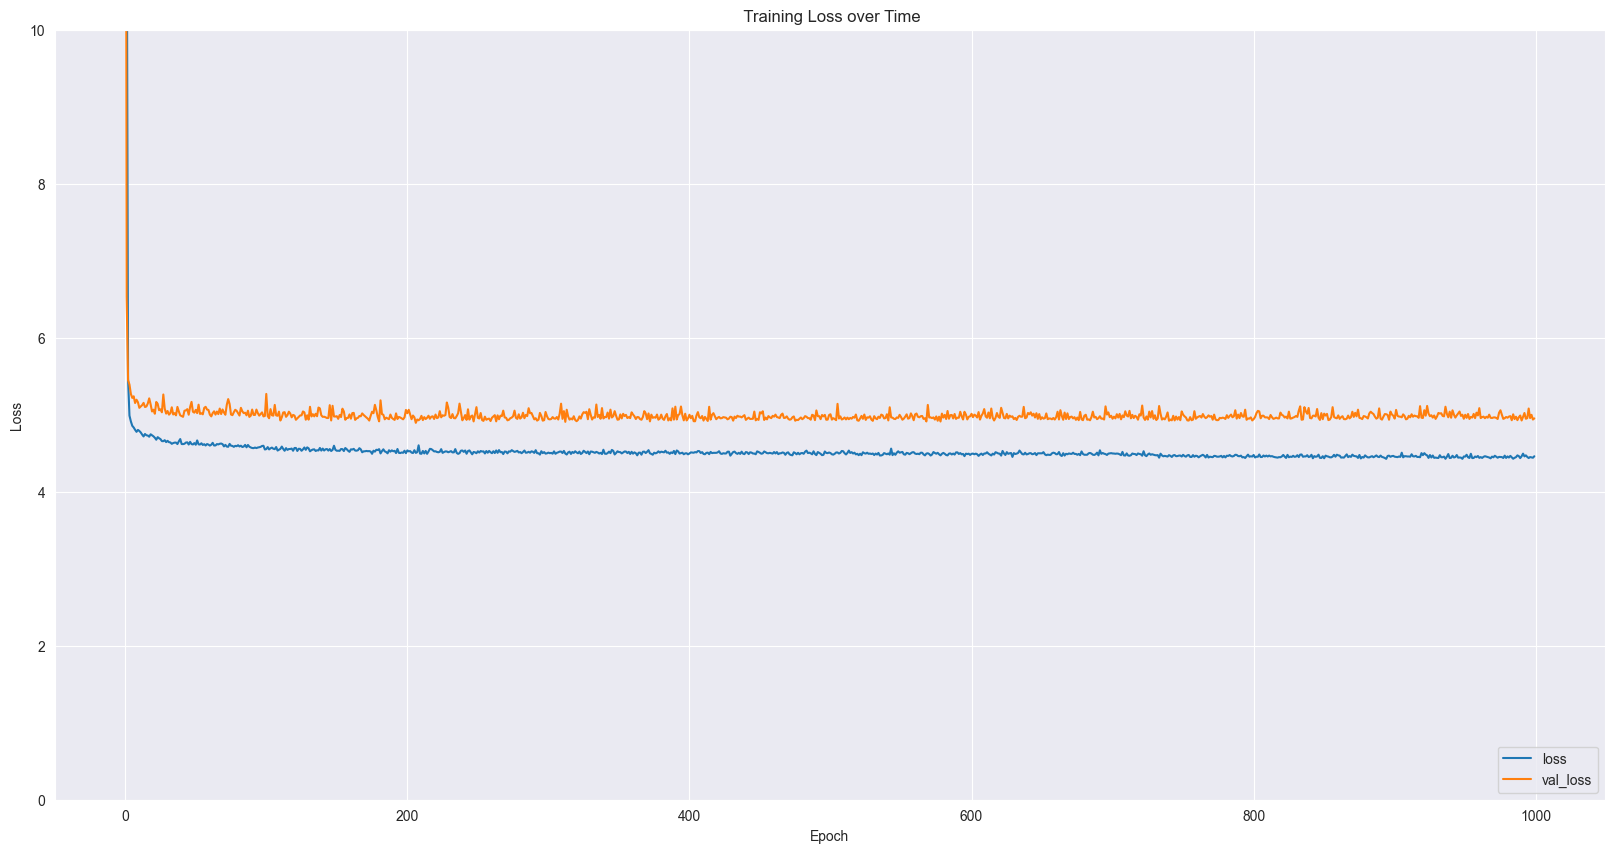

In [5]:
%%time
designr_history = all_models['designr'].fit(
    X_train,
    y_train,
    epochs=NUM_EPOCHS,
    validation_split=VALIDATION_SPLIT,
    callbacks=[designr_checkpoint],
    verbose=0)

all_models['designr'].load_weights(MODEL_CHECKPOINT_FILE)

plot_training_loss(designr_history)


## Regression Model Evaluation

It looks like it's overfitting... but let's keep going... for science.

Recall our scores from the [model selection section](../1-model/model.ipynb):

| Model            | Mean Squared Error | Mean Absolute Error | Explained Variance Score | R2 Score   |
|------------------|--------------------|---------------------|--------------------------|------------|
| untrained_linear | 101.943787         | 9.748023            | 0.049686                 | -13.000124 |
| linear           | 3.997827           | 1.473956            | 0.011232                 | 0.010781   |
| 64_32_16_8_1     | 3.630893           | 1.404292            | 0.302562                 | 0.302399   |
| 32_16_8_1        | 3.602257           | 1.385743            | 0.338213                 | 0.337592   |
| 16_8_1           | 3.807182           | 1.415440            | 0.280600                 | 0.279393   |
| 8_1              | 3.794136           | 1.432214            | 0.228980                 | 0.228786   |
| 4_1              | 3.901053           | 1.461622            | 0.178054                 | 0.177953   |
| 2_1              | 3.946111           | 1.468480            | 0.044709                 | 0.044348   |

***Note**: Above scores by models trained on all features, not the reduced feature set. Let's see if our feature engineering paid off!*



### Score our Model with Reduced Features on Test Data

Drumroll please...


In [6]:
%%time
preds = all_models['designr'].predict(X_test).flatten()
scores_df = score_model(preds, y_test, index='designr')
leaderboard = scores_df.copy()
leaderboard[:]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
CPU times: total: 15.6 ms
Wall time: 92.8 ms


,mean_squared_error,mean_absolute_error,explained_variance_score,r2_score
designr,4.921363,1.648444,-0.223884,-0.22421


##### Mean Squared Error

All around worse than the linear model. We overfit the data.

##### Mean Absolute Error

The worst of the bunch. Pathetic!

##### Explained Variance Score

Into the negatives! We've done it!

##### R2 Score

Truly a disaster. We've overfit and underperformed.

### Compute the ROC Curve

This is a regression problem, so the ROC curve is more of a challenge.

First, we need to convert our predictions into True/False. Since we are trying to predict a crab's age,
a threshold of 2 years is a good starting point. If the prediction is within 2 years of the actual, we'll consider it a success.

#### Convert Predictions to True/False

**Threshold:** 2 years


In [7]:
%%time
## Convert Predictions to True/False based on threshold of 2 years
# get absolute difference between prediction and actual


CPU times: total: 0 ns
Wall time: 0 ns


### True/False Predictions - Scatter Plot


CPU times: total: 0 ns
Wall time: 9.09 ms


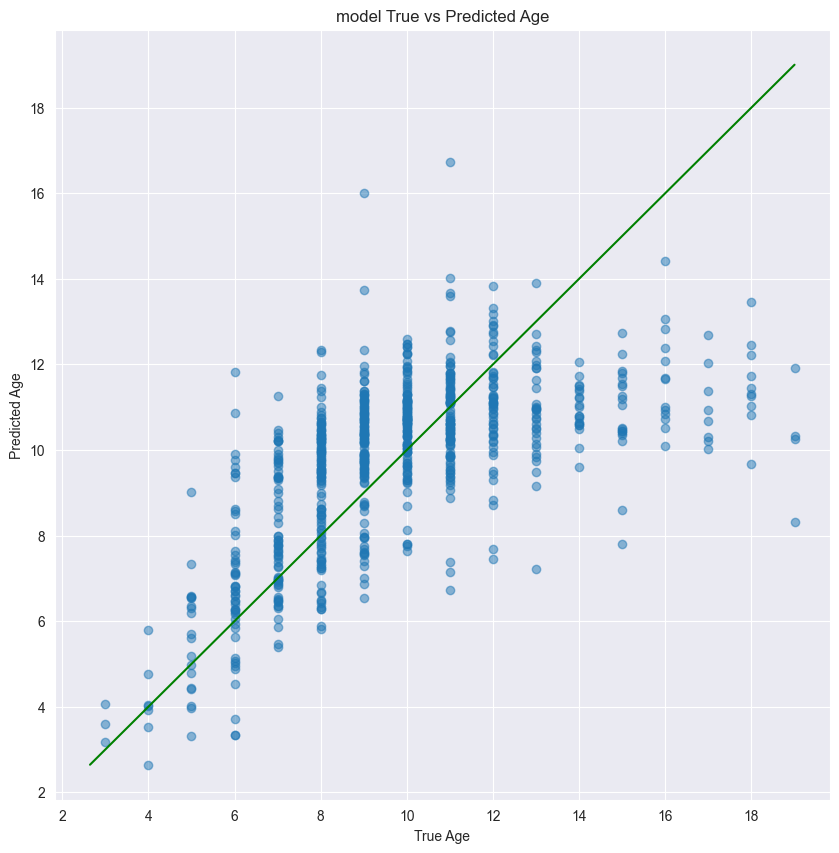

In [8]:
%%time
all_preds = {
    'model': {'true': y_test, 'pred': preds},
}

plot_true_vs_pred_from_dict(all_preds, show_target_line=True)


#### Observations: Scatter Plot

Likely due to the overfitting, our model is not predicting crab ages so well.

- Much older crabs are predicted to be as old as average.
    - This is not a big problem, since they would be ready for eatin' either way.
- Younger crabs are predicted to be slightly older.
    - This could be a problem, since their growth rate is significantly higher at younger ages.
  

## Important Findings

#### Avoid Data Leakage!

While cleaning the data during EDA, we avoided data leakage.

- Didn't use test data to normalize values.
- Avoided filling missing values with the mean or median of the *entire* dataset.
- Checked for duplicate rows, columns before and after splitting the data.

In more general terms, *data leakage* is the phenomenon when the form of a label "leaks" into the training feature set.
An example this of occurred in 2021 for diagnosing Covid patients. Patients lying down on a bed were more likely to be "diagnosed" with Covid.
This is because patients confirmed to have Covid were more inclined to bed rest (Huyen, 2022). 

#### Importance of Data Shuffling

Shuffling the data is important to avoid any biases in the data.
The order of data shouldn't matter, so shuffling helps mitigate any biases.

Shuffling should occur before the test-train split to be most effective.

We don't have to worry about time-series data right now
(although we could reverse order by 'Age' and call it time-series by new feature 'Crab Birthdate'),
but shuffling can have a big impact on the model's performance.


CPU times: total: 93.8 ms
Wall time: 106 ms


array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'Diameter'}>],
       [<Axes: title={'center': 'Height'}>,
        <Axes: title={'center': 'Weight'}>]], dtype=object)

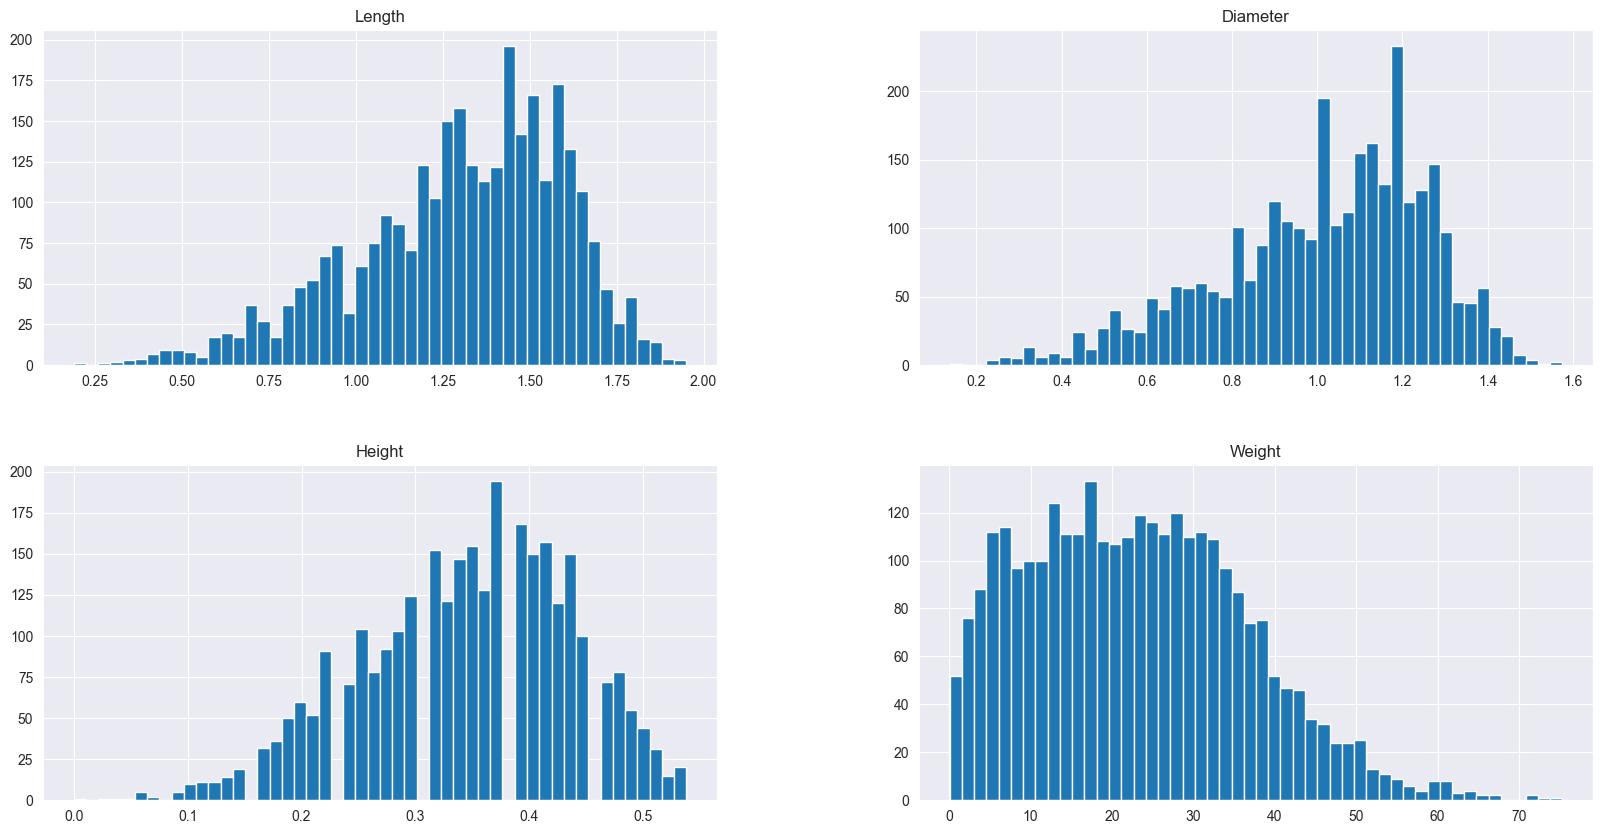

In [9]:
%%time
# Plotting the distribution of the features
X_train.hist(figsize=(20, 10), bins=50)


CPU times: total: 0 ns
Wall time: 26.1 ms


<Axes: >

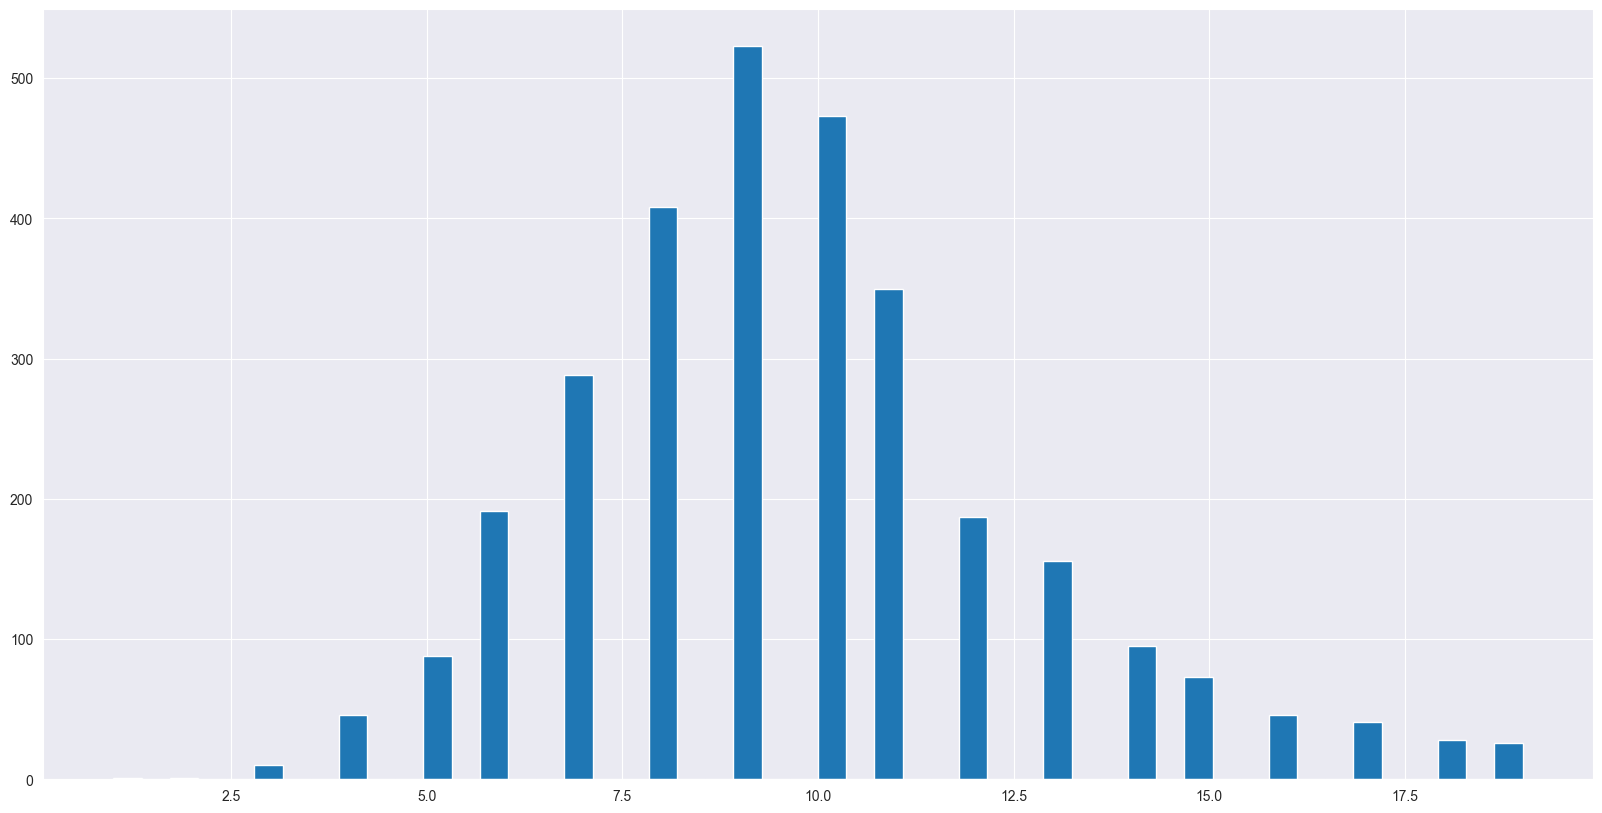

In [10]:
%%time
# Plotting the distribution of the target
y_train.hist(figsize=(20, 10), bins=50)


#### Observations: Histogram

- `Length` and `Diameter` features have a similar distribution.
    - Makes me wonder if they are correlated as well.
- `Height` has a very skewed distribution.
    - Log transformation may help here.
- All `*Weight` features have distribution skewed low.
    - Normalization might help here as well.
- `Age` seems to have a normal distribution.
    - This is good for regression tasks.
        - We won't have to worry about oversampling or undersampling.
    - They must estimate the age of the crab with mainly even numbers.



CPU times: total: 9.02 s
Wall time: 8.94 s


Text(0.5, 1.0, 'Pair Plot Graphs')

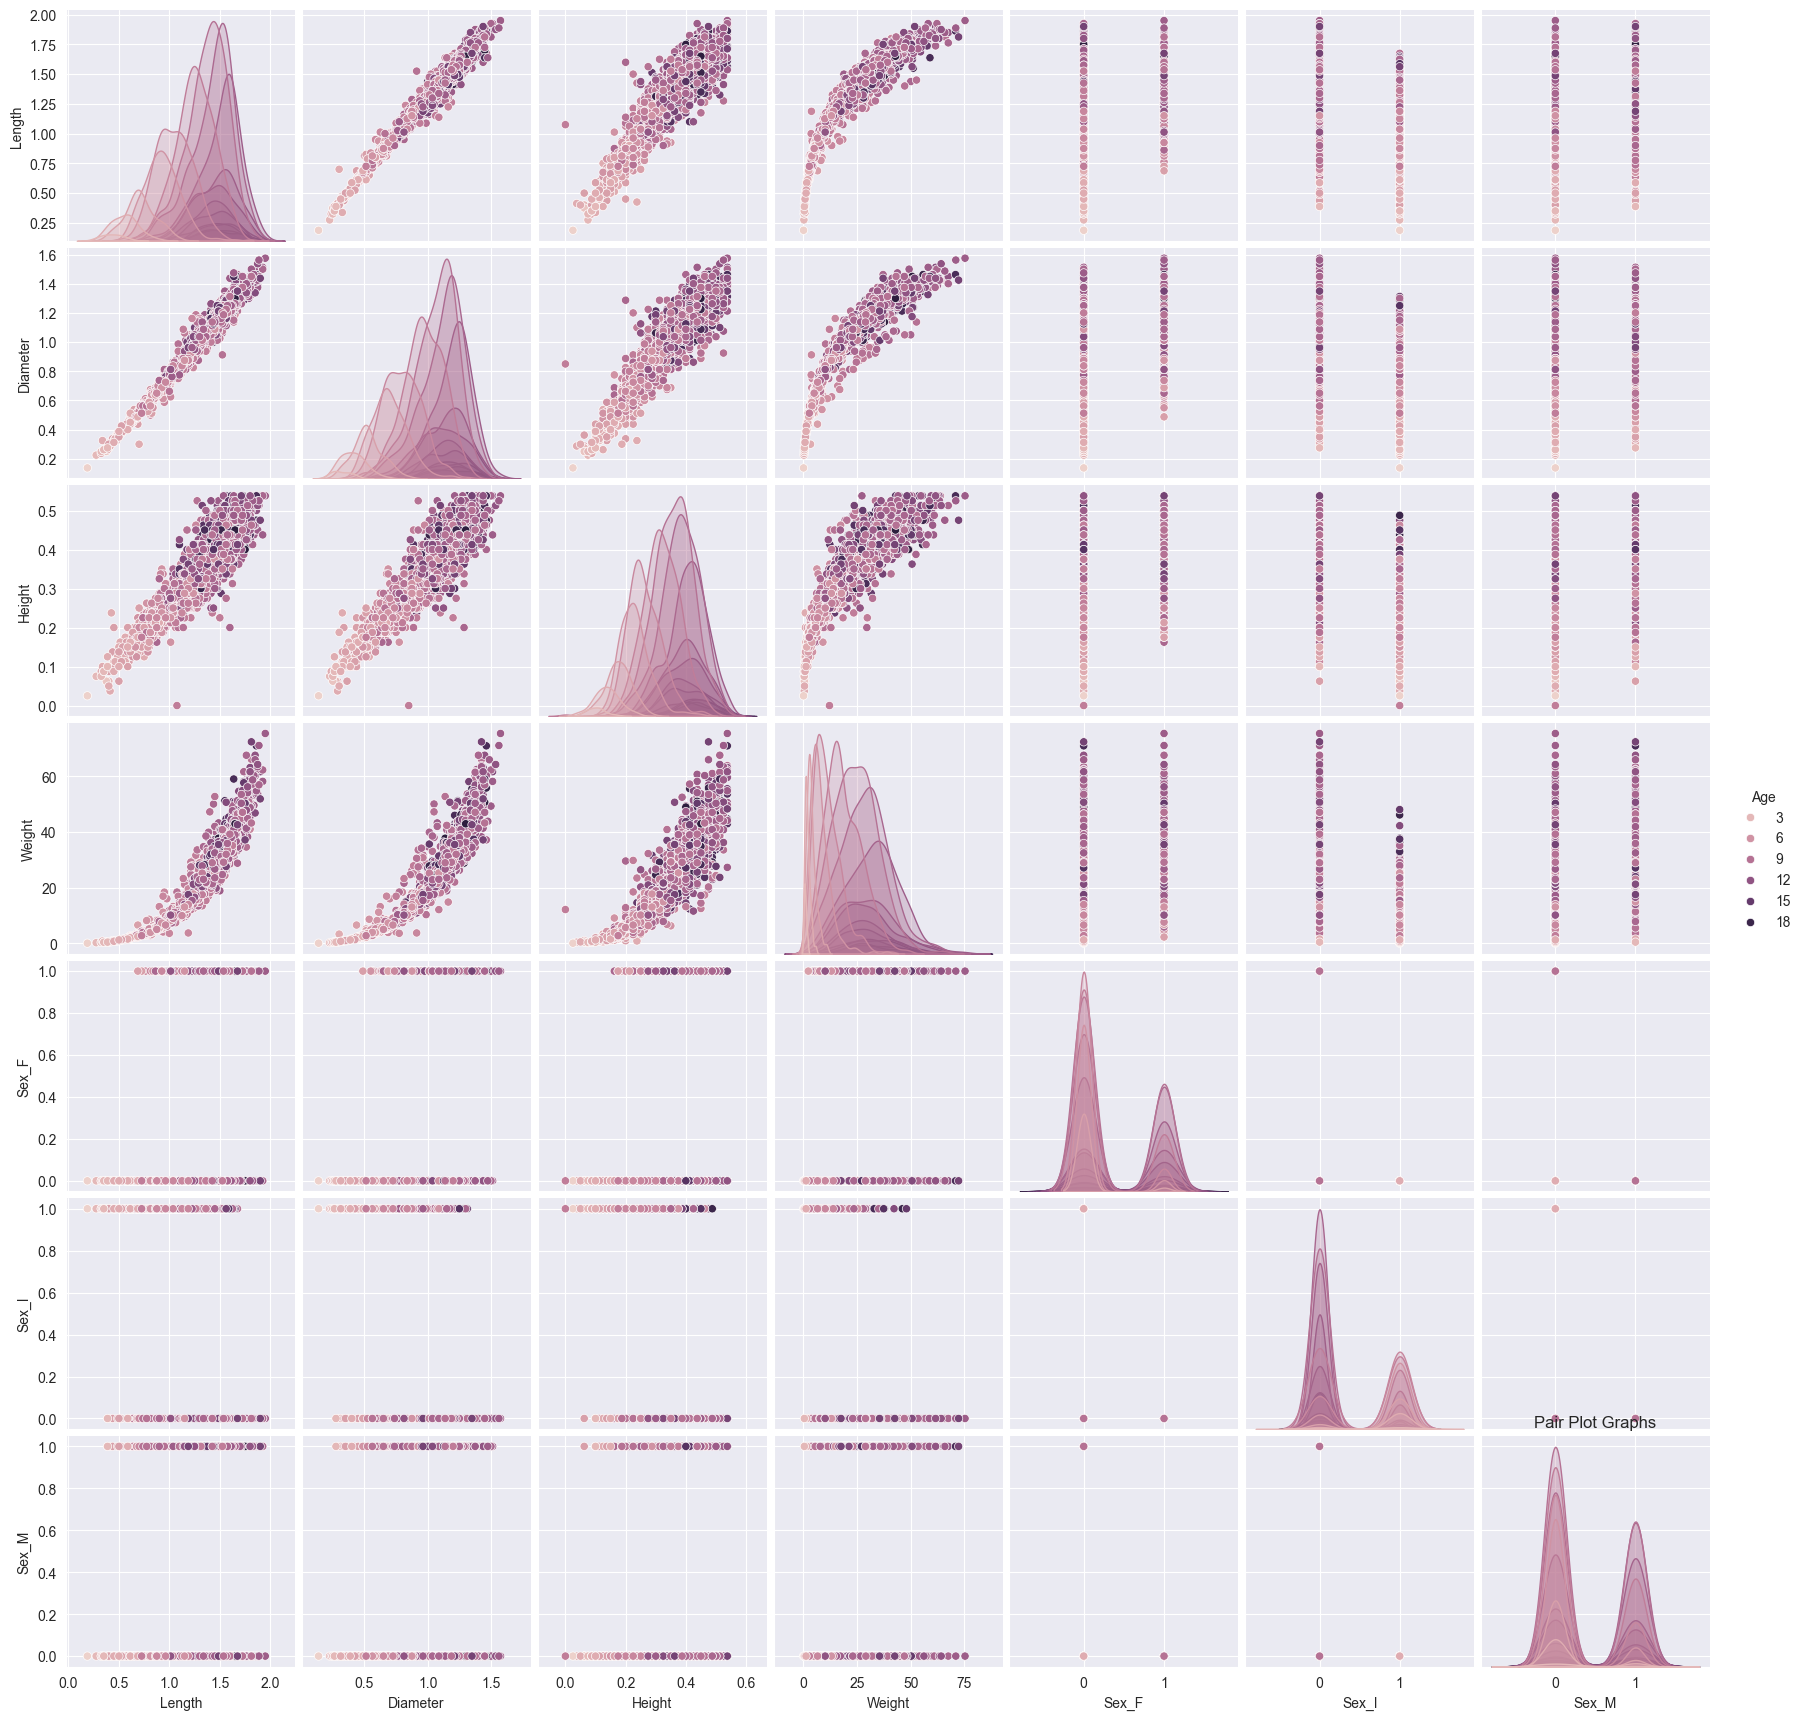

In [11]:
%%time
# Plotting the pair plot to check the correlation between the Target Label and other features
sns.pairplot(crabs, hue=PREDICTION_TARGET)
plt.title('Pair Plot Graphs')


#### Observations: Pair Plot

We are missing some of the features in the pair plot. This is because we removed them during the feature selection process.

- `Length` and `Diameter` are highly correlated.
    - This makes sense since they are both measurements of the same thing.
        - Perhaps we missed an opportunity to reduce the number of features further here.
- Many of the different weight measurements were correlated.
    - Multicollinearity might've been an issue here.
        - Or it helped us overfit...



#### Observations: Heatmap Correlation Matrix

- `Sex_I` is negatively correlated with `Age`.
    - This makes sense since it's more difficult to determine the sex of younger crabs.
- `Length` and `Diameter` are highly correlated.
    - This makes sense since they are both measurements of the same thing.
- Many of the different weight measurements are correlated.
    - Multicollinearity might be an issue here.
- Most size features excluding `Shucked Weight` have similar correlations with `Age`.
    - `Shucked Weight` might not be a good feature, since this kills the crab.


## Conclusion

We have evaluated our crab age regression model on the reduced feature set, and it did not perform as well as we had hoped.
Unfortunately, we overfit the data by selecting the complexity of our model before feature reduction.
In practice, we should reduce the number of features before selecting the model architecture.

Working on this project has been a great learning experience.
I learned a lot about feature engineering, data leakage, and regression metrics.
I also happened to learn a lot about crabs. Do not eat the part under the shell!
It contains a toxin that can cause paralytic shellfish poisoning.
For this reason, it is not recommended to eat the "butter" or "mustard" of the crab.
Those legs are mighty tasty though!

Upon learning about multicollinearity, I realized that the different weight measurements were likely correlated.
This could have been a factor in our model's poor performance. Maybe those correlations were necessary for the model to perform well.
Or maybe we just overfit the data by using too complex of a model. We could find out with a few more tests, but time is running dry.

We tuned the hyperparameters of our model to try to improve its performance, but that area seems to suffer from the curse of dimensionality.
Perhaps we could use some ML algorithms to tune the hyperparameters for us, but that is a project for another day.

Overall, I am happy with the knowledge I have gained from working on this project,
and I look forward to many future machine learning projects.

[References](../refs.bib)
